# Influencer Analyse basierend auf Zentralitätsmetriken über dem Twitter Streamer Netzwerk

## Leitfragen Projekt 
- "Wer sind die **5 einflussreichsten Twitter Influencer** im **Game Streaming** Bereich?"


## TO-DO 
- Warum sieht der Graph so aus wie er ist? (*Diagnostic Analysis*) DONE
  - ist der Graph zufällig entstanden: zufällig vs systematisch generierte Graphen erkennen Anhand von Metriken.

- Multiple logisitische Regression (*Predictive Analysis*) DONE
    - mit Zentralitätsmetrikwerten Game Kategorien/ Followeranzahl vorhersagen
    - **Welche Erfolgsfaktoren(wen kennen, wie verbunden, Metriken) existieren im Netzwerk?**

    
    

## graph measures 
### full network:
- Density
- Average Clustering Coefficient
- Reciprocity
- Triadic Closure
- Bridges
- Center
- Diameter 


### individual nodes:
- Degree Centrality
- Eigenvector Centrality
- PageRank
- Betweenness Centrality
- Closeness Centrality


In [2]:
import pandas as pd
import networkx as nx
import nxviz as nv 
#from nxviz import annotate
#import community
#import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
#load the nx graph object, stored in a pickle file
G = nx.read_gpickle("who_follows_who_new2.pickle")

In [4]:
#inspect graph object
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 78
Number of edges: 1223
Average in degree:  15.6795
Average out degree:  15.6795


In [5]:
print([d["amount"] for n1, n2, d in G.edges(data=True) if d["amount"]<5000])

[2979, 4043, 4493, 3164, 3584, 4145, 4087, 4947, 4419, 4376, 3991, 4668, 628, 4877, 3320, 3968, 4419, 3139, 2361, 2951, 3289, 1681, 2093, 2743, 4695, 2596, 3469, 2168, 3090, 215, 4926, 3698, 2124, 1934, 3153, 2375, 744, 1591, 602, 2661, 1813, 211, 1525, 3125, 783, 1066, 634, 1225, 2965, 4323, 453, 3191, 1468, 1934, 2168, 1263, 3345, 4351, 288, 984, 1121, 2603, 3681, 2765, 247, 42, 1623, 311, 1747, 1109, 4186, 1426, 2329, 582, 459, 3681, 4461, 647, 313, 3329, 2152, 3585, 4182, 301, 2811, 4461, 4625, 3302, 2775, 1001, 2327, 2760, 3905, 1938, 3345, 2735, 3352, 1504, 3417, 2167, 1734, 764, 2521, 2076, 2119, 475, 1855, 669, 4860, 346, 1263, 1101, 1768, 313, 1495, 2070, 1393, 378, 3169, 1714, 3338, 651, 4353, 1815, 2979, 2674, 945, 3550, 3802, 3005, 4792, 2840, 4326, 2073, 4181, 3289, 1893, 4956, 2984, 4625, 2167, 4318, 2449, 2197, 2323, 3322, 4351, 3329, 3191, 4376, 3302, 2152, 1734, 2575, 2674, 4956, 1647, 932, 3422, 2816, 2319, 4841, 3908, 1051, 1769, 3645, 3991, 2965, 280, 4181, 2748, 28

In [6]:
print([d for n, d in G.nodes(data=True) if d["followerCount"]<5000])

[{'followerCount': 1845.0, 'game': 15.0}, {'followerCount': 663.0, 'game': 15.0}, {'followerCount': 2056.0, 'game': 6.0}, {'followerCount': 4835.0, 'game': 4.0}, {'followerCount': 2105.0, 'game': 10.0}, {'followerCount': 4406.0, 'game': 14.0}, {'followerCount': 3007.0, 'game': 11.0}, {'followerCount': 3866.0, 'game': 17.0}]


In [7]:
#FITLER OUT EDGES 
def filter_graph(G, minimum_amount):
    """
    Filter the graph such that
    only edges that have minimum_amount or more of followerCount and sharedFollowers
    are present.
    """
    G_filtered = G.copy()
    #iterate over edges, return nodes u,v of edge and since data=True also the edge's metadata
    for u, v, d in G.edges(data=True):
        if d["amount"] < minimum_amount:
            G_filtered.remove_edge(u, v)
    for n,d in G.nodes(data=True):
        if d["followerCount"] < minimum_amount:
            G_filtered.remove_node(n)
    return G_filtered

In [8]:
#G = filter_graph(G,5000)
#print(nx.info(G))

In [9]:
#add inverse weight to edge metadata
for _,_,d in G.edges(data=True):
    if d["amount"]>0:
        d["inv_amount"]=1/d["amount"]

    else:
        d["inv_amount"]=0
         

In [10]:
#normalize edge weights by sum of all edges weights
sum_amounts=sum([d["amount"] for _,_,d in G.edges(data=True)])
#print(sum_amounts)
for _,_,d in G.edges(data=True):
    if d["amount"]>0:
        d["amount_norm"]=d["amount"]/sum_amounts

    else:
        d["inv_amount"]=0 

In [11]:
#check if new metadata got added to edges
print(list(G.edges(data=True))[0:3])

[('Broeki2', 'BasoStream', {'amount': 7323, 'inv_amount': 0.00013655605626109517, 'amount_norm': 0.00022701080798363812}), ('Broeki2', 'KalleKoschinsky', {'amount': 9983, 'inv_amount': 0.00010017028949213663, 'amount_norm': 0.0003094700117575665}), ('Broeki2', 'itsmahluna', {'amount': 6801, 'inv_amount': 0.00014703720041170417, 'amount_norm': 0.00021082896423552135})]


In [12]:
print(list(G.nodes(data=True))[0:3])

[('Broeki2', {'followerCount': 36999.0, 'game': 5.0}), ('BasoStream', {'followerCount': 36775.0, 'game': 11.0}), ('Lara_Loft', {'followerCount': 86413.0, 'game': 6.0})]


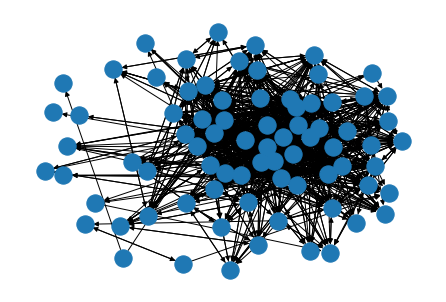

In [13]:
pos=nx.spring_layout(G, k=1,iterations=30)#k=distance between nodes from 0.1 to 1
nx.draw(G, with_labels=False, pos=pos)


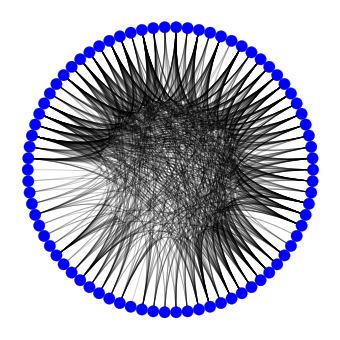

In [14]:

c = nv.plots.CircosPlot(G, node_order='followerCount')
c.draw()
plt.show() 

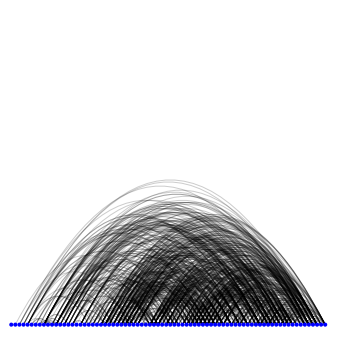

In [15]:
c = nv.plots.ArcPlot(G, node_order='followerCount')
c.draw()
plt.show() 

In [16]:
#How many followers do the isolated nodes have?
isolated_nodes = list(nx.isolates(G))
for node, d in G.nodes(data=True):
    if node in isolated_nodes:
        print(node)
        print(d["followerCount"])


In [17]:
#remove isolated nodes
'''
G.remove_nodes_from(list(nx.isolates(G)))
nx.draw(G, with_labels=True)
'''

'\nG.remove_nodes_from(list(nx.isolates(G)))\nnx.draw(G, with_labels=True)\n'

### Network Density
How many edges exist compared to maximum amount of possible edges in graph

In [18]:
#DENSITY: How many edges exist compared to max amount possible edges
density = nx.density(G)
print("Network density:", density)

Network density: 0.20362970362970362


### Average Clustering Coefficient

It is observed that people who share connections in a social network tend to form associations. In other words, there is a tendency in a social network to form clusters. 

We can determine the clusters of a node, Local Clustering Coefficient, which is the **fraction of pairs of the node's neighbors (that is connections) that are connected with each other.**

If we calculate this for every node in the graph, and divide it by the total number of nodes, we get the average clustering coefficient of the graph!

As an example, fully connected graph has a clustering coefficient of 1.



In [19]:
#CLUSTERING COEFFICIENT
nx.average_clustering(G)

0.5246719773662819

In [20]:
#RECIPORCITY
nx.algorithms.overall_reciprocity(G)

0.7833197056418643

In [21]:
# is the ratio of all triangles over all possible triangles. 
#So transitivity, like density, expresses how interconnected a graph is 
#in terms of a ratio of actual over possible connections.
#Transitivity allows you a way of thinking about all 
#the relationships in your graph that may exist but currently do not.

triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.49361909766534046


## Interpretation Density & CC

Clustering Coefficient ist **hoch** mit 0.5247! 
- vielzahl der möglichen Kanten existieren
- Streamer sind **sehr gut vernetzt**
- vgl. Politiker Netzwerk: 0.43

### Degree Centrality

This approach takes into account only the immediate neighbors of a node that are directly connected and not the entire structure of the network.

Degree centrality can tell you about the biggest hubs, but it can’t tell you that much about the rest of the nodes.

**d=n/N=number of neighbors/total nodes in graph.**

In [22]:
# We use the in-built degree_centrality method
deg_cen = nx.degree_centrality(G)

In [23]:
print(deg_cen)

{'Broeki2': 0.4545454545454546, 'BasoStream': 0.4545454545454546, 'Lara_Loft': 0.8311688311688312, 'Tayronlivereal': 0.27272727272727276, 'DennisWerth_': 0.3116883116883117, 'DerKeller15': 0.06493506493506494, 'PainLivestream': 0.4415584415584416, 'mortenroyale': 0.18181818181818182, 'BigSpinCR': 0.18181818181818182, 'KalleKoschinsky': 0.6233766233766234, 'dannyreturns': 0.4285714285714286, 'chess24de': 0.025974025974025976, 'chesscom_de': 0.012987012987012988, 'katooyoooo': 0.25974025974025977, 'maxlivestream': 0.05194805194805195, 'itsmahluna': 0.6233766233766234, 'TrilluXe': 0.7142857142857143, 'H0llyLP': 0.6363636363636364, '99DAMAGEde': 0.1168831168831169, 'WhiteCatOsu': 0.025974025974025976, 'RevedTV': 0.7142857142857143, 'fayesxh': 0.06493506493506494, 'Dhalucard': 0.8441558441558442, 'BonjwaMental': 0.6363636363636364, 'Vlesk': 0.7662337662337663, 'AnniTheDuck': 0.7272727272727273, 'Gnu_Official_': 0.7142857142857143, 'TolkinLoL': 0.24675324675324678, 'Dekarldent': 0.5844155844

In [24]:
result_df=pd.DataFrame(columns=["degree centrality", "weighted degree", "eigenvector", "betweenness", "page rank", "weighted page rank"])

In [25]:
# The following expression sorts the dictionary by
# degree centrality and returns the top 5 from a graph

deg_cen_res=sorted(deg_cen.items(),
       key=lambda x:x[1],
       reverse=True)[0:5]
print(deg_cen_res)
result_df["degree centrality"]=deg_cen_res

[('mcky_tv', 1.077922077922078), ('rewinside', 1.025974025974026), ('MontanaBlack', 0.8831168831168832), ('Dhalucard', 0.8441558441558442), ('Lara_Loft', 0.8311688311688312)]


In [26]:
result_df.head()

,degree centrality,weighted degree,eigenvector,betweenness,page rank,weighted page rank
0,"(mcky_tv, 1.077922077922078)",NaN,NaN,NaN,NaN,NaN
1,"(rewinside, 1.025974025974026)",NaN,NaN,NaN,NaN,NaN
2,"(MontanaBlack, 0.8831168831168832)",NaN,NaN,NaN,NaN,NaN
3,"(Dhalucard, 0.8441558441558442)",NaN,NaN,NaN,NaN,NaN
4,"(Lara_Loft, 0.8311688311688312)",NaN,NaN,NaN,NaN,NaN


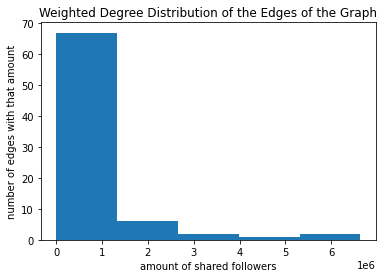

In [27]:
def weighted_degree(G, weight):
    w_deg = {}
    for n in G.nodes():#look at every node
        nbrs = list(G.neighbors(n)) #get nodes neighbors
        nbrs.append(n)
        S = G.subgraph(nbrs)#create a subgraph with the node and its neighbors
        w_deg[n]=sum([d["amount"] for n1,n2,d in S.edges(data=True) if n1==n or n2==n])
    #print(w_deg)
    return w_deg

plt.title("Weighted Degree Distribution of the Edges of the Graph")
plt.hist(list(weighted_degree(G, 'amount').values()), bins=5)
plt.xlabel("amount of shared followers")
plt.ylabel("number of edges with that amount")
plt.show()

In [28]:
#top 5 streamer: Summe der Kantengewichte - wieviele Follower 
#teilt der Knoten mit allen seinen Nachbarn 
weighted_deg_res= sorted(weighted_degree(G, 'amount').items(), key=lambda x:x[1], reverse=True)[0:5]
result_df["weighted degree"]=weighted_deg_res

### Eigenvector Centrality

How many of my neighbors are also important hubs? (hub=node which points to many other nodes)

It is a kind of extension of degree centrality — it looks at a combination of a node’s edges and the edges of that node’s neighbors, **by counting how many links its connections(neighbors) have**
. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to.
It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality. 

Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly. If you know a lot of well-connected people, you could spread a message very efficiently


In [29]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
eig_res= sorted(eigenvector_dict.items(),
       key=lambda x:x[1], reverse=True)[0:5]
print(eig_res)
result_df["eigenvector"]=eig_res

[('rewinside', 0.24294295444066646), ('mcky_tv', 0.21305328144387958), ('Papaplatte', 0.2102559062680845), ('MontanaBlack', 0.20476596533315022), ('AnniTheDuck', 0.20323786107929373)]


# Closeness centrality

finding the individuals who are best placed to influence the entire network most quickly.

measures the average path length. thus the higher your closeness centrality value, the more your node is close to other nodes in your network. (geographic centrality)

In [30]:

clo_cen = nx.closeness_centrality(G)
clo_res= sorted(clo_cen.items(),
       key=lambda x:x[1], reverse=True)[0:5]
print(clo_res)
result_df["closeness"]=clo_res

[('rewinside', 0.6600458365164248), ('MontanaBlack', 0.6411873840445269), ('mcky_tv', 0.6351384464592011), ('Papaplatte', 0.6233766233766234), ('Trymacs_YT', 0.6233766233766234)]


### Betweenness Centrality

definition: **sum of the fraction of all-pairs shortest paths that pass through a node.**

If we imagine that we have to pass a message on a graph from one node to another, then there may be "bottleneck" nodes for which if they are removed, then messages have a harder time flowing through the graph.

Betweenness centrality measures this form of importance. On a graph through which a generic "message" is flowing, a node with a high betweenness centrality is one that has a high proportion of shortest paths flowing through it. In other words, it behaves like a bottleneck.

-> finds nodes which are **structurally important to the network, which binds the network together and densely**.

related important terms:

- *Bonding social capital*: connections within a group
- *Briging social capital*: connections between groups

A healthy society needs a sweet spot of bonds within groups and bridges between groups -> *small world network* 
-	Six degrees of seperation between any american 
-	Describes our neurons in the brain


In [31]:
# First check unweighted (just the structure)
between_res = sorted(nx.betweenness_centrality(G).items(),
       key=lambda x:x[1], reverse=True)[0:5]
print(between_res)
result_df["betweenness"]=between_res

[('mcky_tv', 0.09811725134319217), ('rewinside', 0.06030461658607781), ('Lara_Loft', 0.055871244142610604), ('AmarCoDTV', 0.05499876413866832), ('MontanaBlack', 0.04611836464746561)]


### Page Rank

It is based on measuring the popularity of a website.

- **Probability that in a random walk, at time t, a page is reached**
- It only depends on the **link structure** of the web -> not on it's content
- for a node, it analyzes the structure of **incoming** links
    - an incoming edge to a node increases the score
    - it is about **quality** links 


In [32]:
#PAGERANK
# by default weight attribute in PageRank is weight
# so we use weight=None to find the unweighted results
sorted_pr = sorted(nx.pagerank_numpy(G,
                weight=None).items(),
                key=lambda x:x[1], reverse=True)[0:5]

result_df["page rank"]=sorted_pr

for node in sorted_pr[0:5]:
    print(node)
#-> all have the same PR

('MontanaBlack', 0.03552560567342818)
('rewinside', 0.034594344035208474)
('mcky_tv', 0.027990217756600665)
('Lara_Loft', 0.026203983864016994)
('Papaplatte', 0.0260461866888966)


In [33]:
#PageRank using the weights of the edges
#devalue some edges based on their weight.
sorted_pr_weights = sorted(nx.pagerank_numpy(
    G, weight='amount').items(),
    key=lambda x:x[1], reverse=True)[0:5]
print(sorted_pr_weights)

result_df["weighted page rank"]=sorted_pr_weights

[('Julien_Bam', 0.07850602608576818), ('MontanaBlack', 0.07611030513347783), ('rewinside', 0.0726059629283812), ('Gronkh', 0.0588821269450861), ('Taddl', 0.04685240025131238)]


Ein erster Unterschied im Top-5 Ranking ergibt sich beim gewichteten PageRank (betrachtet auch die Gewichte der Kanten): TrilluXe hat einen höheren PageRank, als BasoStream, obwohl letzerer mehr gemeinsame Follower mit anderen Streamern im Datensatz teilt (56449) als TrilluXe(55197). 

In [34]:
#normalized weights
sorted(nx.pagerank_numpy(
    G, weight='amount_norm').items(),
    key=lambda x:x[1], reverse=True)[0:5]

[('Julien_Bam', 0.07850602608576814),
 ('MontanaBlack', 0.0761103051334778),
 ('rewinside', 0.07260596292838119),
 ('Gronkh', 0.05888212694508613),
 ('Taddl', 0.04685240025131237)]

In [35]:
result_df

,degree centrality,weighted degree,eigenvector,betweenness,page rank,weighted page rank,closeness
0,"(mcky_tv, 1.077922077922078)","(rewinside, 6634656)","(rewinside, 0.24294295444066646)","(mcky_tv, 0.09811725134319217)","(MontanaBlack, 0.03552560567342818)","(Julien_Bam, 0.07850602608576818)","(rewinside, 0.6600458365164248)"
1,"(rewinside, 1.025974025974026)","(Julien_Bam, 6240702)","(mcky_tv, 0.21305328144387958)","(rewinside, 0.06030461658607781)","(rewinside, 0.034594344035208474)","(MontanaBlack, 0.07611030513347783)","(MontanaBlack, 0.6411873840445269)"
2,"(MontanaBlack, 0.8831168831168832)","(MontanaBlack, 4309360)","(Papaplatte, 0.2102559062680845)","(Lara_Loft, 0.055871244142610604)","(mcky_tv, 0.027990217756600665)","(rewinside, 0.0726059629283812)","(mcky_tv, 0.6351384464592011)"
3,"(Dhalucard, 0.8441558441558442)","(Taddl, 3916452)","(MontanaBlack, 0.20476596533315022)","(AmarCoDTV, 0.05499876413866832)","(Lara_Loft, 0.026203983864016994)","(Gronkh, 0.0588821269450861)","(Papaplatte, 0.6233766233766234)"
4,"(Lara_Loft, 0.8311688311688312)","(Gronkh, 2826272)","(AnniTheDuck, 0.20323786107929373)","(MontanaBlack, 0.04611836464746561)","(Papaplatte, 0.0260461866888966)","(Taddl, 0.04685240025131238)","(Trymacs_YT, 0.6233766233766234)"


In [36]:
final_df = result_df.drop(columns=["weighted degree", "weighted page rank"])

In [37]:
final_df

,degree centrality,eigenvector,betweenness,page rank,closeness
0,"(mcky_tv, 1.077922077922078)","(rewinside, 0.24294295444066646)","(mcky_tv, 0.09811725134319217)","(MontanaBlack, 0.03552560567342818)","(rewinside, 0.6600458365164248)"
1,"(rewinside, 1.025974025974026)","(mcky_tv, 0.21305328144387958)","(rewinside, 0.06030461658607781)","(rewinside, 0.034594344035208474)","(MontanaBlack, 0.6411873840445269)"
2,"(MontanaBlack, 0.8831168831168832)","(Papaplatte, 0.2102559062680845)","(Lara_Loft, 0.055871244142610604)","(mcky_tv, 0.027990217756600665)","(mcky_tv, 0.6351384464592011)"
3,"(Dhalucard, 0.8441558441558442)","(MontanaBlack, 0.20476596533315022)","(AmarCoDTV, 0.05499876413866832)","(Lara_Loft, 0.026203983864016994)","(Papaplatte, 0.6233766233766234)"
4,"(Lara_Loft, 0.8311688311688312)","(AnniTheDuck, 0.20323786107929373)","(MontanaBlack, 0.04611836464746561)","(Papaplatte, 0.0260461866888966)","(Trymacs_YT, 0.6233766233766234)"


In [38]:
print("Top 5 Streamer by Follower Count")
print(sorted([(d["followerCount"], n) for n, d in G.nodes(data=True)],
    key=lambda x:x, reverse=True)[0:5])

Top 5 Streamer by Follower Count
[(1724776.0, 'Julien_Bam'), (1563457.0, 'Taddl'), (1383174.0, 'rewinside'), (1327568.0, 'Gronkh'), (979483.0, 'MontanaBlack')]


In [39]:
print(G.nodes["rewinside"])
print(G.nodes["mcky_tv"])
print(G.nodes["Lara_Loft"])

{'followerCount': 1383174.0, 'game': 4.0}
{'followerCount': 160497.0, 'game': 4.0}
{'followerCount': 86413.0, 'game': 6.0}


# Interpretation

## Allgemein
**rewinside** und **mcky_tv** sind strukturell die wichtigsten Knoten im Netzwerk. Sie sind über alle Messwerte hinweg am stärksten mit dem Rest des Graphen verbunden, durch
- degree: hat die lokal größte Anzahl an Nachbarn
- betweenness: Summe kürzester Pfade, hält das Netzwerk zusammen
- page rank: hat die wichtigsten Follower
- closeness: ist am nähesten zu allen anderen Streamern

Eine **Ausnahme** liefert **Page Rank** für **mcky_tv**, siehe mehr unten.

**Überrraschenderweise** tauchen **Taddl** und **Gronkh nicht untern den Top 5 Knoten** auf, **obwohl** die beiden unter den **Top 5 Streamer mit der größten Followerzahl sind**. Es folgt, dass Sie eher zweitrangige Bedeutung für das Netzwerk haben, und kleinere Streamer eine wichtigere Rolle im Netzwerk spielen!

## entscheidende Metriken
- beste Vernetzung eines Knoten im Netzwerk: Eigenvektor Zentralität
- Einfluss auf Informationsfluss: Betweeness Centrality
- **rewinside und mcky_tv sind die wichtigsten Influencer!**

## Betweeness Centrality
Auf Platz 1 befindet sich **überraschend mcky_tv**, der nur Platz 17 in der **Followeranzahl** ist, mit 160.497 Followern (Platz 1 Julian Bam: 1.724.776.0). Ansonsten ist das Ergebnis nicht überraschend, denn mcky_tv hat gleichzeitig auch die größte degree centrality!(In dem Fall überraschen Lara_Loft und AmorCoDTV, die 20 Streamer weniger als Nachbarn haben im vgl. zu mcky_tv, aber dennoch oben im Ranking laden) 

Daraus folgt, dass **mcky_tv**, zwar nicht die meisten Follower und Reichweite unter den Streamern hat, aber dennoch **höchst relevant für das Streamer Netzwerk** ist, da er es **dicht zusammenhält** und den **Informationsfluss bestimmt**. Er hat das größte **briging capital**, er baut eine *Brücke* zwischen einzelnen Gruppierungen. 



## Eigenvector Centrality
Gibt an, welche Knoten das gesamte Netzwerk beeinflussen, indem Sie zu wichtigen Knoten verbunden sind. 
- hohe und wichtige Vernetzung der Knoten (qualitativ und quantitiv)
- wenn man viele gut vernetzte Streamer kennt, kann man eine Nachricht schneller verbreiten!


**rewinside** dominiert klar, auf Platz 2 folgt **mcky_tv**. Eine gute Alternative stellt **Papaplatte** auf Platz 3 dar, ein Streamer mit nur 300.000 Followern - er liegt ebenfalls bei der closeness centrality dicht hinter mcky_tv


## Page Rank
**MontanaBlack und rewinside** haben den höhsten Score, ihnen folgen also strukturell wichtige Knoten im Netzwerk (eingehende Kanten). Wenn wir die gemeinsamen Follower als Kantengewichte mit einbeziehen, werden die beiden Streamer von **JulianBam** getopt - bedeutet, dass JulianBam von Streamern gefolgt wird, die viele gemeinsame Follower mit ihm haben. (macht das Sinn?)


## Fazit
- most influencial big streamer: rewinside
- most infleuncial small streamer: mcky_tv (aber auch INSGESAMT)
- alternatives: Papalatte (Eig Centr Platz 3), MontanaBlack (PageRank, Closeness)


### What if you want to know which of the high betweenness centrality nodes had low degree? 
### That is to say: which high-betweenness nodes are unexpected?

In [40]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted(nx.betweenness_centrality(G).items(),
       key=lambda x:x[1], reverse=True)[:20]

degree_dict= nx.degree(G)
deg_cen
#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)
    

Name: mcky_tv | Betweenness Centrality: 0.09811725134319217 | Degree: 83
Name: rewinside | Betweenness Centrality: 0.06030461658607781 | Degree: 79
Name: Lara_Loft | Betweenness Centrality: 0.055871244142610604 | Degree: 64
Name: AmarCoDTV | Betweenness Centrality: 0.05499876413866832 | Degree: 63
Name: MontanaBlack | Betweenness Centrality: 0.04611836464746561 | Degree: 68
Name: maximmarkow | Betweenness Centrality: 0.04499808406898154 | Degree: 60
Name: itsmahluna | Betweenness Centrality: 0.03965200152695197 | Degree: 48
Name: KalleKoschinsky | Betweenness Centrality: 0.03532432259832078 | Degree: 48
Name: TrilluXe | Betweenness Centrality: 0.03499462346741993 | Degree: 55
Name: TANZVERBOTcf | Betweenness Centrality: 0.03344120793322343 | Degree: 56
Name: Vlesk | Betweenness Centrality: 0.03336210008904795 | Degree: 59
Name: Dhalucard | Betweenness Centrality: 0.029126119203428422 | Degree: 65
Name: DennisWerth_ | Betweenness Centrality: 0.026422539068566675 | Degree: 24
Name: Gronk

# Connected Components

In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph

In [41]:
ccsubgraph_nodes = list(nx.strongly_connected_components(G))
len(ccsubgraph_nodes)

6

In [42]:
def label_connected_component_subgraphs(G):
    G=G.copy() #defensive 
    ccsubgraph_nodes = list(nx.strongly_connected_components(G))
    idx = len(ccsubgraph_nodes)
    for subgraph in ccsubgraph_nodes:
        label = idx
        for n in subgraph:
            G.nodes[n]["subgraph"]=label
        idx=idx-1
    return G

G_labelled = label_connected_component_subgraphs(G)

In [43]:
G_labelled.nodes(data=True)

NodeDataView({'Broeki2': {'followerCount': 36999.0, 'game': 5.0, 'subgraph': 3}, 'BasoStream': {'followerCount': 36775.0, 'game': 11.0, 'subgraph': 3}, 'Lara_Loft': {'followerCount': 86413.0, 'game': 6.0, 'subgraph': 3}, 'Tayronlivereal': {'followerCount': 28651.0, 'game': 12.0, 'subgraph': 3}, 'DennisWerth_': {'followerCount': 69776.0, 'game': nan, 'subgraph': 3}, 'DerKeller15': {'followerCount': 48037.0, 'game': 16.0, 'subgraph': 3}, 'PainLivestream': {'followerCount': 65306.0, 'game': 16.0, 'subgraph': 3}, 'mortenroyale': {'followerCount': 57965.0, 'game': 22.0, 'subgraph': 3}, 'BigSpinCR': {'followerCount': 14420.0, 'game': 22.0, 'subgraph': 3}, 'KalleKoschinsky': {'followerCount': 51580.0, 'game': 23.0, 'subgraph': 3}, 'dannyreturns': {'followerCount': 72536.0, 'game': 4.0, 'subgraph': 3}, 'chess24de': {'followerCount': 1845.0, 'game': 15.0, 'subgraph': 1}, 'chesscom_de': {'followerCount': 663.0, 'game': 15.0, 'subgraph': 2}, 'katooyoooo': {'followerCount': 12740.0, 'game': 8.0, '

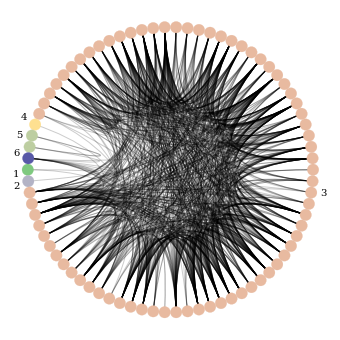

In [44]:
c = nv.plots.CircosPlot(G_labelled,node_grouping="subgraph", node_color="subgraph", 
                        #group_legend=True,
                       group_label_position="middle")
c.draw()
plt.show() 

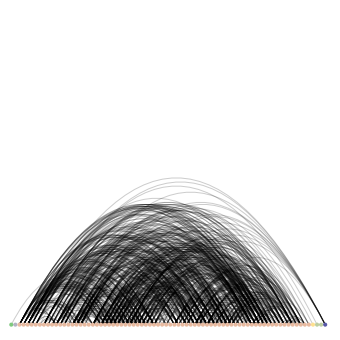

In [45]:
arc = nv.plots.ArcPlot(G_labelled,node_grouping="subgraph", node_color="subgraph"
                      # , node_size="followerCount"
                      )
arc.draw()
plt.show() 

In-Degree Out-Degree Distribution

In [1]:
in_degrees  = G.in_degree() # dictionary node:degree
in_values = sorted(set(in_degrees.values())) 
in_hist = [in_degrees.values().count(x) for x in in_values]

out_degrees  = G.out_degree() # dictionary node:degree
out_values = sorted(set(out_degrees.values())) 
out_hist = [out_degrees.values().count(x) for x in in_values]

plt.figure()
plt.plot(in_values,in_hist,'ro-') # in-degree
plt.plot(out_values,out_hist,'bv-') # out-degree
plt.legend(['In-degree','Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Hartford drug users network')
plt.savefig('hartford_degree_distribution.pdf')
plt.close()

NameError: name 'G' is not defined

In [ ]:
nx.find_cliques(G)

In [ ]:
G = G.to_undirected()
G_components_nodes = list(nx.connected_components(G))
#extract main connected component nodes
G_mc_nodes = G_components_nodes[0]



In [ ]:
G_mc=G.subgraph(G_mc_nodes)
print(nx.info(G_mc))

In [ ]:
nx.draw(G_mc, with_labels=True)

In [ ]:
degs=G_mc.degrees()
nx.degree_histogram(degs)

## Bridges 

In graph theory, a bridge is an edge of a graph whose deletion increases the graph's number of connected components. Equivalently, an edge is a bridge if and only if it is not contained in any cycle. 

In [ ]:
print(nx.has_bridges(G))

In [ ]:
bridges=nx.bridges(G)
print(list(bridges))
#NEXT: find out if bridges are meaningful!
for edge in bridges:
    for n1,n2 in edge:
        print(nx.degree(G,n1))

In [ ]:
# the diameter of a graph is the longest of all possible shortest paths in the graph
# how wide is the graph?
print(nx.diameter(G))

In [ ]:
#A center of a graph is a node where the maximum distance (number of edges) 
#traversed to any other node is a minimum, compared to any other node. 
#Essentially, the center of a graph is the most centrally located node. 
#Note that there may be more than one node that qualifies as the center of the graph.
print(list(nx.center(G)))

In [ ]:
print(nx.info(G))

In [745]:
all_centralities_df = pd.DataFrame()

In [665]:
in_deg_iter = G.in_degree()
print(in_deg_iter)
in_deg=[v for k, v in in_deg_iter]
in_deg

[('Broeki2', 17), ('BasoStream', 19), ('Lara_Loft', 33), ('Tayronlivereal', 5), ('DennisWerth_', 8), ('DerKeller15', 2), ('PainLivestream', 17), ('mortenroyale', 2), ('BigSpinCR', 6), ('KalleKoschinsky', 23), ('dannyreturns', 15), ('chess24de', 0), ('chesscom_de', 1), ('katooyoooo', 4), ('maxlivestream', 2), ('itsmahluna', 21), ('TrilluXe', 26), ('H0llyLP', 15), ('99DAMAGEde', 5), ('WhiteCatOsu', 1), ('RevedTV', 31), ('fayesxh', 1), ('Dhalucard', 30), ('BonjwaMental', 22), ('Vlesk', 30), ('AnniTheDuck', 33), ('Gnu_Official_', 27), ('TolkinLoL', 10), ('Dekarldent', 17), ('AmarCoDTV', 31), ('noway4u_sir', 16), ('orangemorangee', 18), ('Shlorox', 23), ('StaiyLIVE', 23), ('KayzahR', 8), ('Shurjoka', 21), ('Doktor_Froid', 6), ('MailandWoT', 2), ('STYLERZ97', 7), ('jessirocksplays', 2), ('Mexify', 21), ('djanesintica', 13), ('R6esportsDE', 2), ('VadealFN', 8), ('Gronkh', 26), ('xPandorya', 11), ('MontanaBlack', 44), ('LoLSola', 23), ('Agurinlol', 6), ('mcky_tv', 40), ('AgentsRange', 7), ('TA

[17,
 19,
 33,
 5,
 8,
 2,
 17,
 2,
 6,
 23,
 15,
 0,
 1,
 4,
 2,
 21,
 26,
 15,
 5,
 1,
 31,
 1,
 30,
 22,
 30,
 33,
 27,
 10,
 17,
 31,
 16,
 18,
 23,
 23,
 8,
 21,
 6,
 2,
 7,
 2,
 21,
 13,
 2,
 8,
 26,
 11,
 44,
 23,
 6,
 40,
 7,
 28,
 6,
 13,
 38,
 36,
 10,
 12,
 9,
 8,
 43,
 23,
 1,
 29,
 22,
 29,
 22,
 13,
 14,
 16,
 12,
 8,
 21,
 8,
 9,
 8,
 3,
 1]

In [746]:
all_centralities_df["degree"]=nx.degree_centrality(G).values()
all_centralities_df["betweenness"]=nx.betweenness_centrality(G).values()
all_centralities_df["eigenvector"]=nx.eigenvector_centrality(G).values()
all_centralities_df["pagerank"]=nx.pagerank_numpy(G,weight=None).values()
all_centralities_df["closeness"]=nx.closeness_centrality(G).values()
#all_centralities_df["follower"]=[d["followerCount"] for n,d in G.nodes(data=True)]
#all_centralities_df["in_degree"]=in_deg
all_centralities_df["game"]=[d["game"] for n,d in G.nodes(data=True)]

In [747]:
all_centralities_df

,degree,betweenness,eigenvector,pagerank,closeness,game
0,0.454545,0.008887,0.096742,0.014448,0.495034,5.0
1,0.454545,0.003348,0.129003,0.013877,0.521897,11.0
2,0.831169,0.055871,0.189312,0.026204,0.595794,6.0
3,0.272727,0.000742,0.036672,0.005746,0.440031,12.0
4,0.311688,0.026423,0.055636,0.008580,0.457991,NaN
...,...,...,...,...,...,...
73,0.272727,0.001198,0.019463,0.005663,0.384712,8.0
74,0.415584,0.010184,0.029656,0.006446,0.413035,8.0
75,0.194805,0.000107,0.023879,0.005382,0.400742,8.0
76,0.051948,0.000011,0.017044,0.003438,0.384712,18.0


In [763]:
all_centralities_df.dropna(inplace=True)

In [798]:
all_centralities_df = all_centralities_df.loc[(all_centralities_df['game'] == 4.0) | 
                                              (all_centralities_df['game'] == 5.0) |
                                             (all_centralities_df['game'] == 6.0) | 
                                             (all_centralities_df['game'] == 8.0) |
                                             (all_centralities_df['game'] == 12.0)]

In [801]:
all_centralities_df.game.unique()

array([ 5.,  6., 12.,  4.,  8.])

In [802]:
all_centralities_df.describe()

,degree,betweenness,eigenvector,pagerank,closeness,game
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.482018,0.014068,0.109488,0.015000,0.502091,5.730769
std,0.259507,0.019545,0.067270,0.008123,0.083091,2.284778
min,0.012987,0.000000,0.001294,0.002687,0.284070,4.000000
25%,0.246753,0.001198,0.044367,0.008610,0.439316,4.000000
50%,0.474026,0.008546,0.110317,0.014320,0.508527,5.000000
75%,0.665584,0.016423,0.162174,0.021625,0.556518,6.000000
max,1.077922,0.098117,0.242943,0.035526,0.660046,12.000000


In [645]:
# TODO remove rows where follower<100.000
all_centralities_df=all_centralities_df[all_centralities_df.follower<=100000]

In [803]:
all_centralities_df.shape

(52, 6)

In [804]:
corrMatrix = all_centralities_df.corr()
print (corrMatrix)

               degree  betweenness  eigenvector  pagerank  closeness      game
degree       1.000000     0.814098     0.921987  0.911509   0.898909 -0.176254
betweenness  0.814098     1.000000     0.673699  0.754734   0.676853 -0.160488
eigenvector  0.921987     0.673699     1.000000  0.957049   0.968591 -0.279993
pagerank     0.911509     0.754734     0.957049  1.000000   0.956589 -0.304557
closeness    0.898909     0.676853     0.968591  0.956589   1.000000 -0.267217
game        -0.176254    -0.160488    -0.279993 -0.304557  -0.267217  1.000000


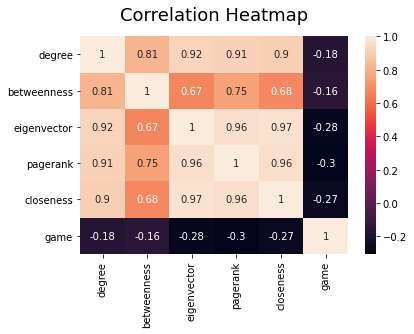

'\nmost CM are highly correlated on the full data\nif we reduce follower outliers, \nonly betweenness centrality shows smaller correlations to the rest of the measures, \nthe others remain highly correlated\n'

In [806]:
heatmap=sn.heatmap(corrMatrix, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.savefig("game_corr_heatmap_pp.png", dpi=300, bbox_inches='tight')
plt.show()
##INTERPRETATION
'''
most CM are highly correlated on the full data
if we reduce follower outliers, 
only betweenness centrality shows smaller correlations to the rest of the measures, 
the others remain highly correlated
'''

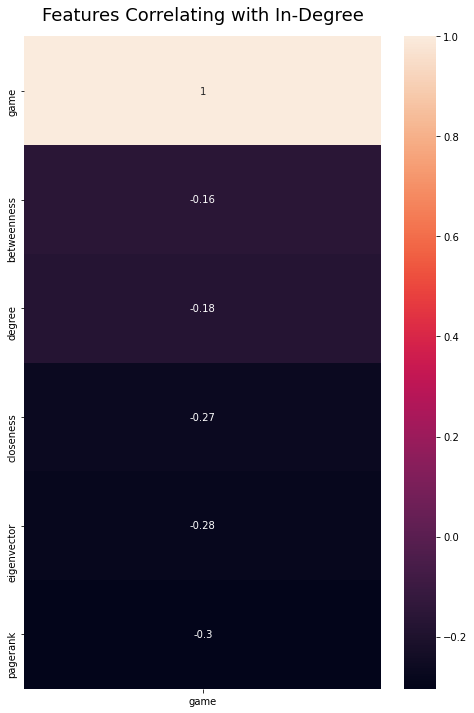

In [807]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(all_centralities_df.corr()[['game']].sort_values(by="game", ascending=False),annot=True)
heatmap.set_title('Features Correlating with In-Degree', fontdict={'fontsize':18}, pad=16);
plt.savefig('indeg_corr_list_pp.png', dpi=300, bbox_inches='tight')

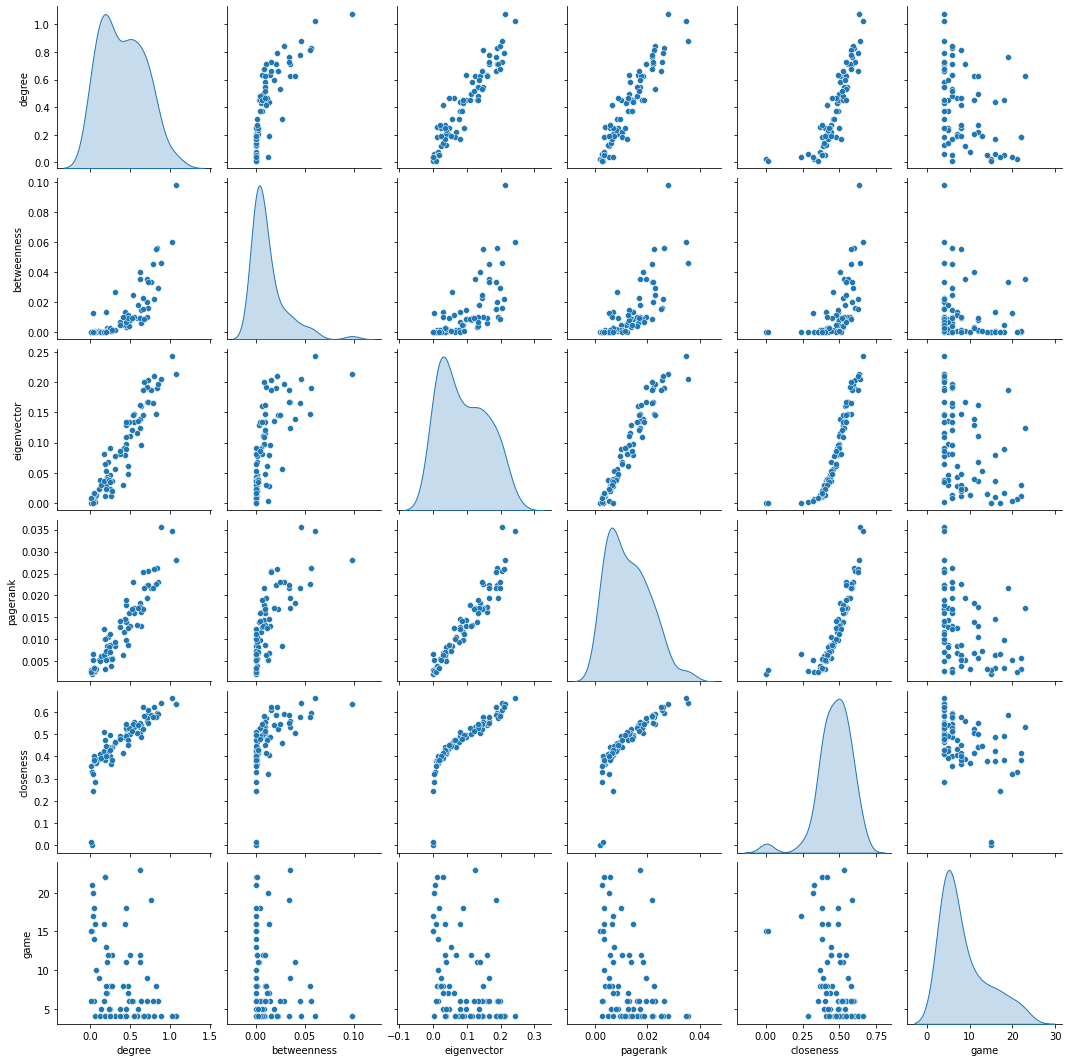

In [756]:
import seaborn as sns
sns.pairplot(all_centralities_df, diag_kind="kde")
plt.savefig('game_pairplot_pp.png', dpi=300, bbox_inches='tight')
#heatmap.set_title('Features Correlating with Follower Count', fontdict={'fontsize':18}, pad=16);
#plt.savefig('follower_corr_list_full.png', dpi=300, bbox_inches='tight')
# Title 
#plt.suptitle('Pair Plot of Centrality Measures for Twitter Streamers with less then 100k followers', 
  #           size = 18)

## Pair Plot Insights: Full Data
- follower distribution highly right-skewed -> remove right tail for better regression performance
- CM strongly positively correlated -> measure same type of power/importance for our network(more then expexted!)
- only BETWEENNESS CENTRALITY does not correlate well with the others -> measures different type of power!

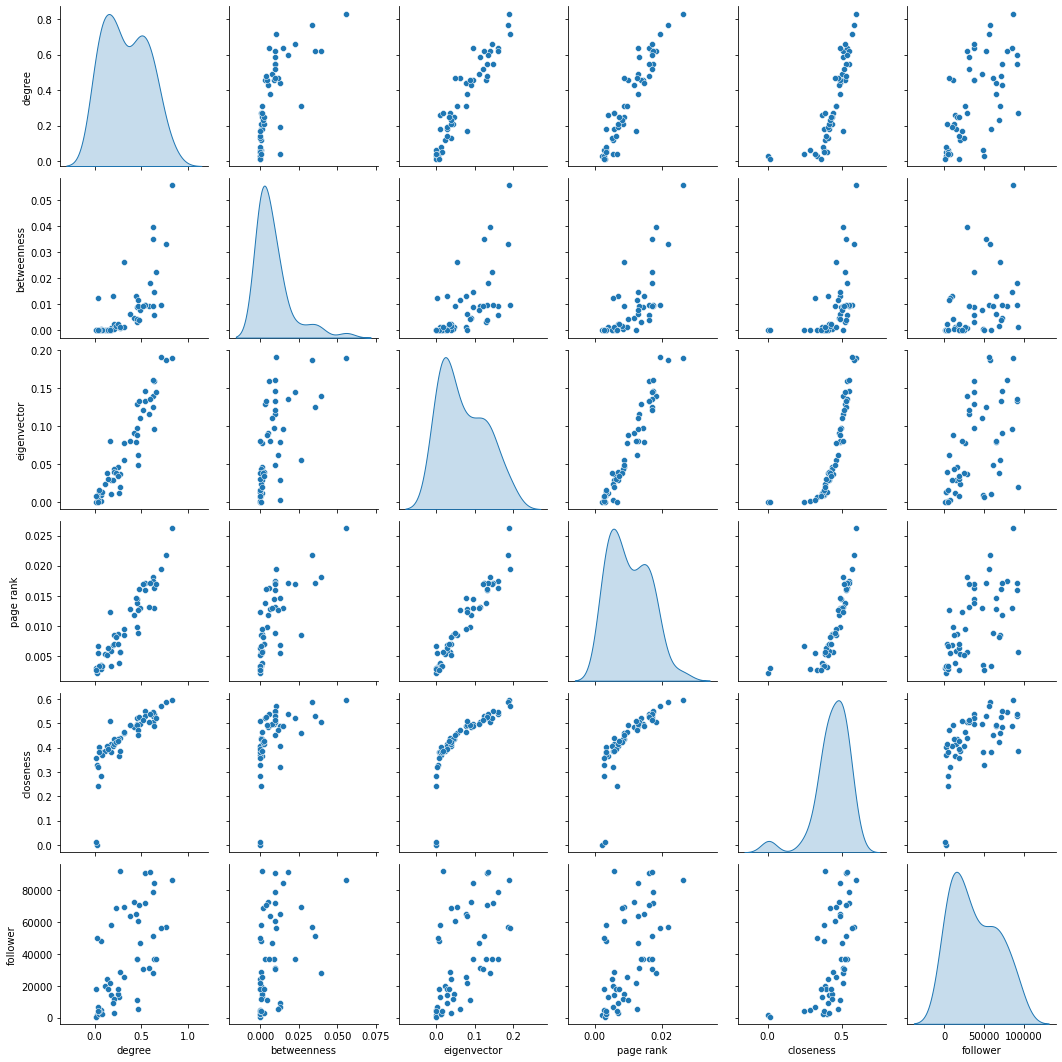

In [379]:
sns.pairplot(all_centralities_df[all_centralities_df.follower<=100000], diag_kind="kde")

## Pair Plot Insights: <100k followers


Histograms:
- Closeness is left-skewed
- Betweenness is right-skewed
- Degree distributions tend to be right-skewed; that is, only a few nodes in most networks have most of the ties. Evenly distributed degree is much rarer -> our network is strongly connected (distributed graph) and this is a special finding

Correlations:
- between the measures strong correlations 
- followers only correlate slighty with measures, mostly its a messy point cloud without structure

In [ ]:
##TODO: PLOT IN DEG AND OUT DEG HIST

In [808]:
X = pd.DataFrame(all_centralities_df.iloc[:,:-1])
#X = all_centralities_df.values
#y1 = [d["followerCount"] for n,d in G.nodes(data=True)if d["followerCount"]<=100000]
y1 = all_centralities_df["game"].to_list()
#y2 = [d["game"] for n,d in G.nodes(data=True)]

In [809]:
X.shape

(52, 5)

In [810]:
y1

[5.0,
 6.0,
 12.0,
 4.0,
 8.0,
 6.0,
 6.0,
 4.0,
 4.0,
 6.0,
 6.0,
 4.0,
 6.0,
 5.0,
 4.0,
 8.0,
 5.0,
 12.0,
 12.0,
 4.0,
 4.0,
 4.0,
 4.0,
 8.0,
 6.0,
 12.0,
 4.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 6.0,
 6.0,
 6.0,
 4.0,
 4.0,
 6.0,
 4.0,
 4.0,
 8.0,
 4.0,
 6.0,
 8.0,
 8.0,
 8.0]

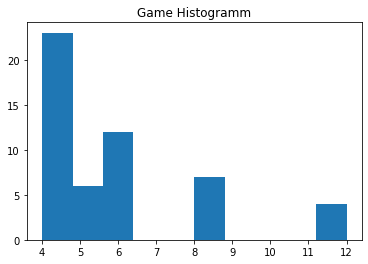

In [811]:
plt.hist(y1, 
         bins=10)
plt.title("Game Histogramm")
plt.savefig('game_hist.png', dpi=300, bbox_inches='tight')

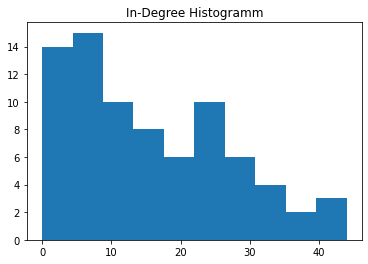

In [686]:
plt.hist(y1, 
         bins=10)
plt.title("In-Degree Histogramm")
plt.savefig('indeg_hist.png', dpi=300, bbox_inches='tight')

In [295]:
len([d["followerCount"] for n,d in G.nodes(data=True)if d["followerCount"]<=200000])

64

In [463]:
len(y1)

78

In [822]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

In [813]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=0)
#X_train= X_train.reshape(-1, 1)
#y_train= y_train.reshape(-1, 1)
#X_test = X_test.reshape(-1, 1)
#y_test= y_test.reshape(-1, 1)


In [773]:
len(y_train)

61

In [814]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [824]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [825]:
print(metrics.accuracy_score(X_train, y_train))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [775]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

18.054111412975374
[  -4.18980154  213.5034511    53.66498829 -787.53169939  -10.32519745]


In [815]:
r_sq = regressor.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.07487501178248301


In [826]:
y_pred = log_reg.predict(X_test)

In [827]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
0,5.0,4.0
1,4.0,4.0
2,4.0,4.0
3,4.0,4.0
4,12.0,4.0
5,4.0,4.0
6,6.0,4.0
7,4.0,4.0
8,4.0,4.0
9,8.0,4.0


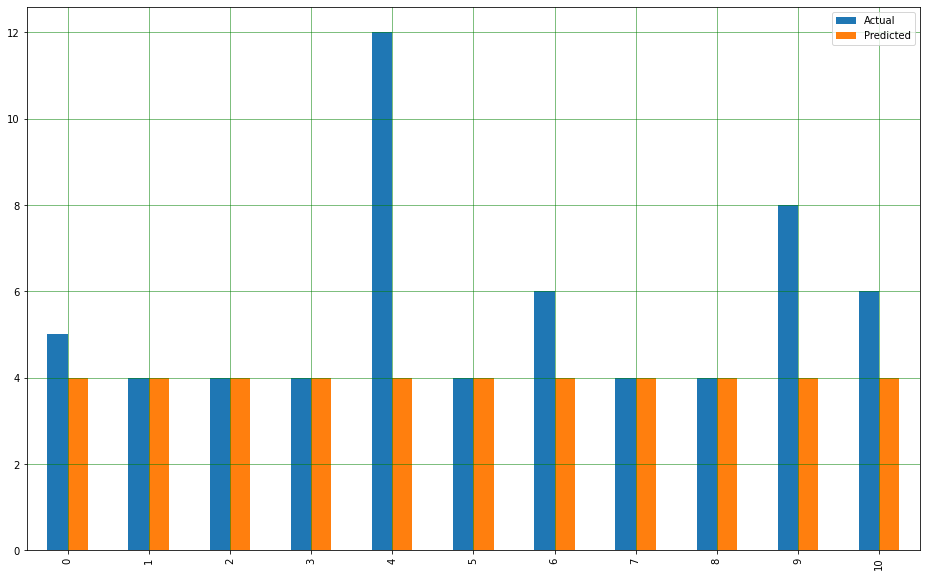

<Figure size 432x288 with 0 Axes>

In [829]:
df1 = df.tail(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
plt.savefig('lr_deg_pred.png', dpi=300, bbox_inches='tight')

In [780]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.540561712166043
Mean Squared Error: 25.712402904964087
Root Mean Squared Error: 5.070739877469962


In [781]:
X_test.shape

(16, 5)

Coefficient of determination: -0.25


ValueError: x and y must be the same size

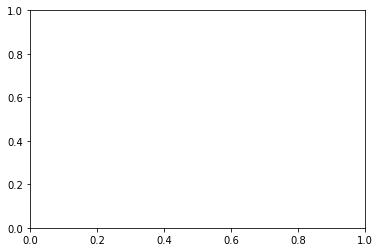

In [782]:
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [783]:
r2_score=metrics.r2_score(y_test, y_pred)
print("Adjusted R^2:", 1-(1-r2_score*(16-1)/(16-1-1))))

Adjusted R^2: -0.26834057689782465


In [710]:
all_centralities_df

,degree,betweenness,eigenvector,pagerank,closeness,in-degree
0,0.454545,0.008887,0.096742,0.014448,0.495034,17
1,0.454545,0.003348,0.129003,0.013877,0.521897,19
2,0.831169,0.055871,0.189312,0.026204,0.595794,33
3,0.272727,0.000742,0.036672,0.005746,0.440031,5
4,0.311688,0.026423,0.055636,0.008580,0.457991,8
...,...,...,...,...,...,...
73,0.272727,0.001198,0.019463,0.005663,0.384712,8
74,0.415584,0.010184,0.029656,0.006446,0.413035,9
75,0.194805,0.000107,0.023879,0.005382,0.400742,8
76,0.051948,0.000011,0.017044,0.003438,0.384712,3


In [796]:
import statsmodels.formula.api as sm

#all_centralities_df[all_centralities_df.follower<=100000]
result = sm.ols(formula="game ~ pagerank",
                  data=all_centralities_df).fit()


print(result.params)
print(result.summary())


Intercept     12.207593
pagerank    -277.364523
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   game   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     15.38
Date:                Mon, 28 Jun 2021   Prob (F-statistic):           0.000193
Time:                        18:30:14   Log-Likelihood:                -231.52
No. Observations:                  77   AIC:                             467.0
Df Residuals:                      75   BIC:                             471.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [491]:
len(y1)

78

In [596]:
#BACKWARD ELIMINATION
#delete var with highest p-value; betweenness
#REPEAT 
result = sm.ols(formula="follower ~ degree + pagerank + eigenvector + closeness",
                  data=all_centralities_df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               follower   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     7.564
Date:                Sun, 27 Jun 2021   Prob (F-statistic):           8.64e-05
Time:                        18:29:01   Log-Likelihood:                -594.12
No. Observations:                  52   AIC:                             1198.
Df Residuals:                      47   BIC:                             1208.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3935.1328   1.66e+04     -0.237      

In [597]:

result = sm.ols(formula="follower ~ degree + closeness + eigenvector",
                  data=all_centralities_df).fit()
print(result.params)
print(result.summary())

Intercept      -2991.598248
degree         81121.403996
closeness      46468.259966
eigenvector   -99933.632532
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               follower   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     10.28
Date:                Sun, 27 Jun 2021   Prob (F-statistic):           2.42e-05
Time:                        18:29:17   Log-Likelihood:                -594.14
No. Observations:                  52   AIC:                             1196.
Df Residuals:                      48   BIC:                             1204.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---

In [598]:

result = sm.ols(formula="follower ~ degree + closeness",
                  data=all_centralities_df[all_centralities_df.follower<=100000]).fit()
print(result.params)
print(result.summary())

Intercept     -150.472555
degree       60148.524599
closeness    40028.711395
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               follower   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     15.45
Date:                Sun, 27 Jun 2021   Prob (F-statistic):           6.25e-06
Time:                        18:29:55   Log-Likelihood:                -594.33
No. Observations:                  52   AIC:                             1195.
Df Residuals:                      49   BIC:                             1201.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [599]:
result = sm.ols(formula="follower ~ degree",
                  data=all_centralities_df).fit()
print(result.params)
print(result.summary())

Intercept    12013.615607
degree       75808.887822
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               follower   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     30.21
Date:                Sun, 27 Jun 2021   Prob (F-statistic):           1.31e-06
Time:                        18:30:03   Log-Likelihood:                -594.76
No. Observations:                  52   AIC:                             1194.
Df Residuals:                      50   BIC:                             1197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------